:::{.callout-note}
This chapter is based on "Chapter 6: Vertical and horizontal transmission" in @Acerbi2022.
:::

## Vertical cultural transmission


In [1]:
import numpy as np 
rng = np.random.default_rng()

import pandas as pd
from tqdm import tqdm

In [2]:
def plot_multiple_runs(data_model):
    groups = data_model.groupby("run")
    for _, g in groups:
        g.index = g["generation"]
        g["p"].plot(lw=.5, ylim=(0,1))

    data_model.groupby("generation")["p"].mean().plot(c="k", lw="1")

In [3]:
def vertical_transmission(N, p_0, b, t_max, r_max):
    # Create the output DataFrame
    output = pd.DataFrame({
        "generation" : np.tile(np.arange(t_max), r_max),
        "p" : [ np.nan ] * t_max * r_max,
        "run" : np.repeat(np.arange(r_max), t_max)
    })

    for r in range(r_max): 
        # Create first generation
        population = pd.DataFrame({"trait": rng.choice(["A", "B"], size=N, replace=True, p=[p_0, 1 - p_0])})

        # Add first generation's p for run r
        output.loc[ r * t_max, "p"] = population[ population["trait"] == "A" ].shape[0] / N

        # # For each generation 
        for t in range(1, t_max): 
            # Copy individuals to previous_population DataFrame
            previous_population = population.copy()

            # randomly pick mothers and fathers
            mother = previous_population["trait"].sample(N, replace=True).reset_index(drop=True)
            father = previous_population["trait"].sample(N, replace=True).reset_index(drop=True)

            # prepare next generation
            population = pd.DataFrame({"trait": [np.nan] * N })

            # Both parents are A, thus child adopts A
            both_A = (mother == "A") & (father == "A")
            # if sum(both_A) > 0:
            population.loc[both_A,"trait"] = "A"

            # Both parents are A, thus child adopts A
            both_B = (mother == "B") & (father == "B")
            # if sum(both_B) > 0:
            population.loc[both_B,"trait"] = "B"

            # If any empty NA slots are present (i.e. one A and one B parent) they adopt A with probability b
            remaining = rng.choice(["A", "B"], size=population["trait"].isna().sum(), replace=True, p=[b, 1 - b])
            population.loc[population["trait"].isna(),"trait"] = remaining
            
            # Get p and put it into output slot for this generation t and run r
            output.loc[r * t_max + t, "p"] = population[ population["trait"] == "A" ].shape[0] / N

    return output 

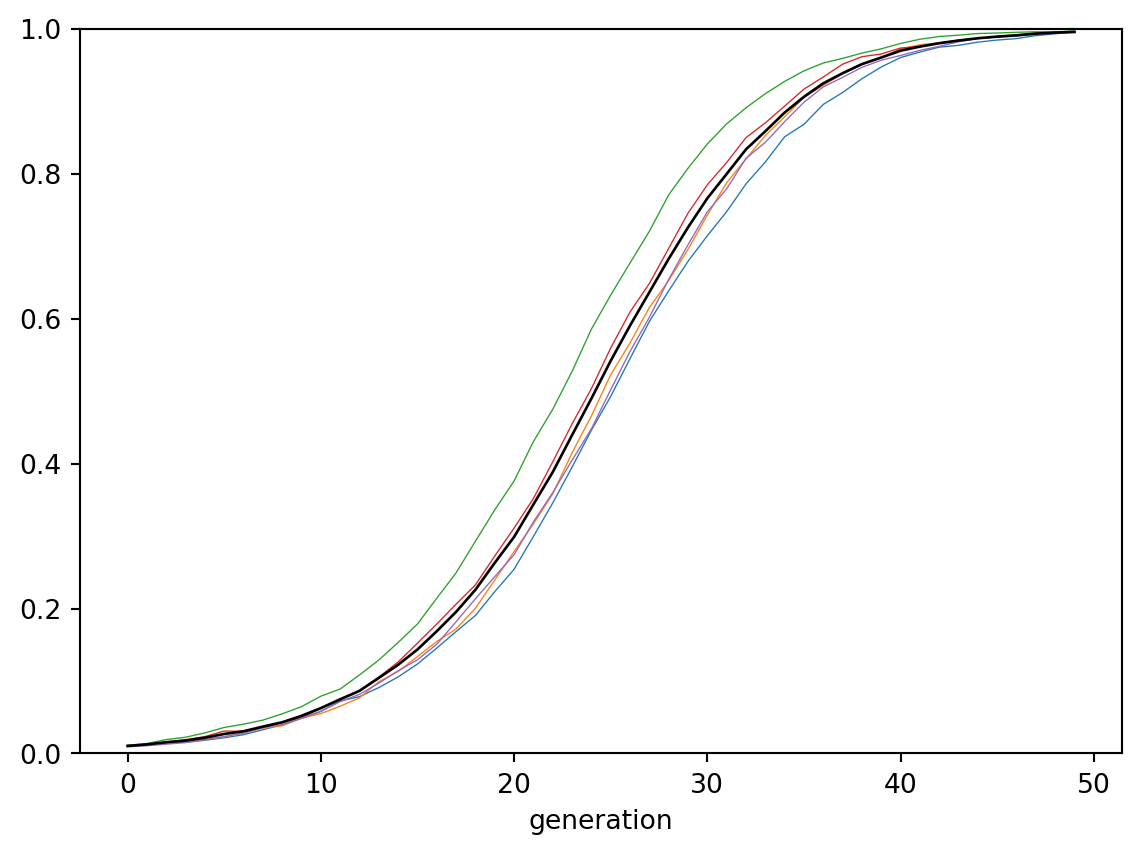

In [4]:
data_model = vertical_transmission(N=10_000, p_0=0.01, b=0.6,t_max=50, r_max=5)

plot_multiple_runs(data_model)

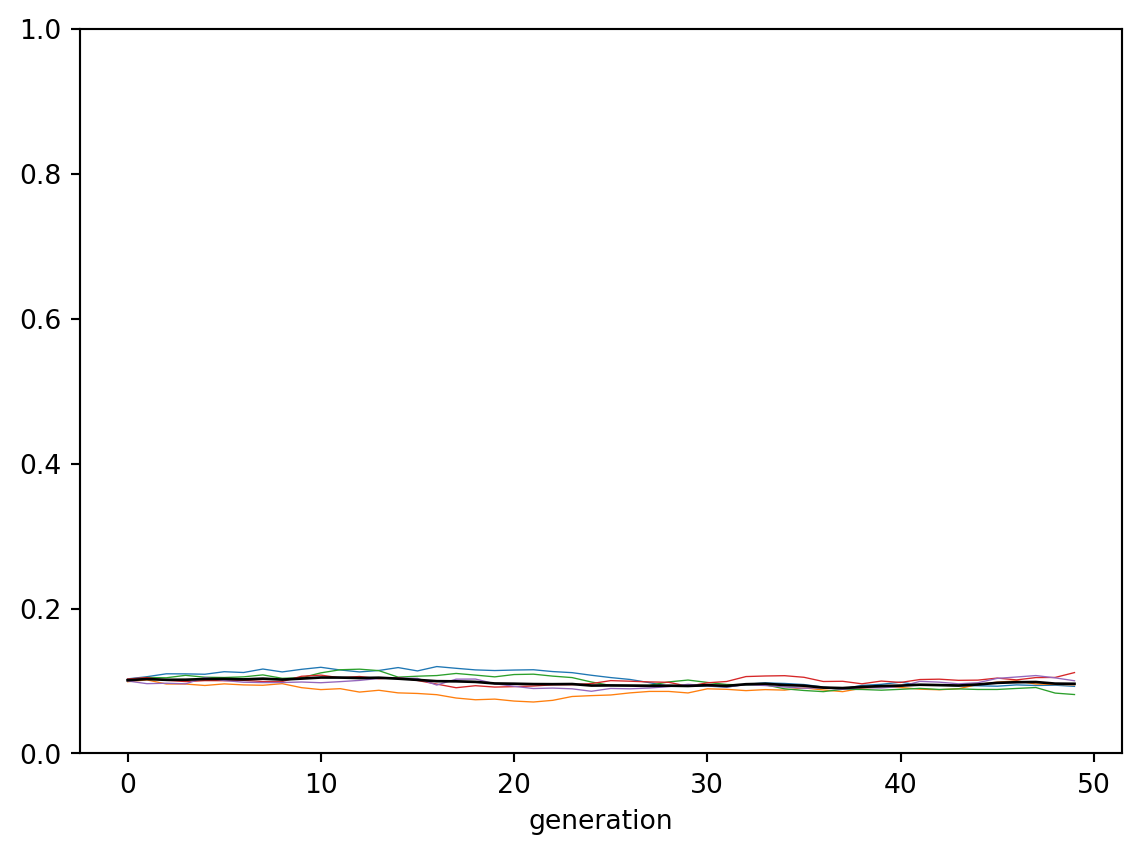

In [5]:
data_model = vertical_transmission(N=10_000, p_0=0.1, b=0.5,t_max=50, r_max=5)
plot_multiple_runs(data_model)

## Horizontal cultural transmission

::: {.callout-warning}
The code below is not yet correct and runs very slowly.
:::


In [6]:
def vertical_horizontal_transmission(N, p_0, b, n, g, t_max, r_max):
    # Create the output DataFrame
    output = pd.DataFrame({
        "generation" : np.tile(np.arange(t_max), r_max),
        "p" : [ np.nan ] * t_max * r_max,
        "run" : np.repeat(np.arange(r_max), t_max)
    })

    for r in range(r_max):
        # Create first generation
        population = pd.DataFrame({"trait": rng.choice(["A", "B"], size=N, replace=True, p=[p_0, 1 - p_0])})

        # Add first generation's p for run r
        output.loc[ r * t_max, "p"] = population[ population["trait"] == "A" ].shape[0] / N

        # For each generation 
        for t in tqdm(range(t_max)):
            ### Vertical transmission =========================================================

            # Copy individuals to previous_population DataFrame
            previous_population = population.copy()

            # randomly pick mothers and fathers
            mother = previous_population["trait"].sample(N, replace=True).reset_index(drop=True)
            father = previous_population["trait"].sample(N, replace=True).reset_index(drop=True)

            # prepare next generation
            population = pd.DataFrame({"trait": [np.nan] * N })

            # Both parents are A, thus child adopts A
            both_A = (mother == "A") & (father == "A")
            # if sum(both_A) > 0:
            population.loc[both_A,"trait"] = "A"

            # Both parents are A, thus child adopts A
            both_B = (mother == "B") & (father == "B")
            # if sum(both_B) > 0:
            population.loc[both_B,"trait"] = "B"

            # If any empty NA slots are present (i.e. one A and one B parent) they adopt A with probability b
            remaining = rng.choice(["A", "B"], size=population["trait"].isna().sum(), replace=True, p=[b, 1 - b])
            population.loc[population["trait"].isna(),"trait"] = remaining
            
            # Get p and put it into output slot for this generation t and run r
            output.loc[r * t_max + t, "p"] = population[ population["trait"] == "A" ].shape[0] / N

            # ### Horizontal transmission =========================================================

            # previous_population = population.copy()
            # # # N_B = number of Bs
            # N_B = previous_population[previous_population["trait"] == "B"].shape[0]

            # # if there are B individuals to switch, and n is not zero:
            # if (N_B > 0) & (n > 0):
            #     # for each B individual:
            #     for i in range(N_B):
            #         # Pick n demonstrators
            #         demonstrator = previous_population["trait"].sample(n, replace=True)
            #         # Get probability g 
            #         copy_ = rng.choice([True, False], n, p=[g, 1 - g], replace=True)
            #         # if any demonstrators with A are to be copied:
            #         if sum((demonstrator == "A") & (copy_)) > 0:
            #           # The B individual switches to A 
            #           population[previous_population["trait"] == "B"].loc[i, "trait"] = "A"

            next_population = population.copy()
            # # N_B = number of Bs
            N_B = next_population[next_population["trait"] == "B"].shape[0]

            # if there are B individuals to switch, and n is not zero:
            if (N_B > 0) & (n > 0):
                # for each B individual:
                for i in range(N_B):
                    # Pick n demonstrators
                    demonstrator = population["trait"].sample(n, replace=True)
                    # Get probability g 
                    copy_ = rng.choice([True, False], n, p=[g, 1 - g], replace=True)
                    # if any demonstrators with A are to be copied:
                    if sum((demonstrator == "A") & (copy_)) > 0:
                      # The B individual switches to A 
                      next_population[next_population["trait"] == "B"].loc[i, "trait"] = "A"

            # Get p and put it into output slot for this generation t and run r
            output.loc[r * t_max + t, "p"] = next_population[ next_population["trait"] == "A" ].shape[0] / N

    return output

In [7]:
vertical_horizontal_transmission(N=1000, p_0=0.01, b=0.5, n=5, g=0.1, t_max=10, r_max=1)

  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_208727/3300034538.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_population[next_population["trait"] == "B"].loc[i, "trait"] = "A"


 10%|█         | 1/10 [00:00<00:03,  2.29it/s]

 20%|██        | 2/10 [00:00<00:02,  3.09it/s]

/tmp/ipykernel_208727/3300034538.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_population[next_population["trait"] == "B"].loc[i, "trait"] = "A"
 30%|███       | 3/10 [00:00<00:02,  3.21it/s]

 40%|████      | 4/10 [00:01<00:01,  3.48it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.48it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.30it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.36it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.57it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.73it/s]

100%|██████████| 10/10 [00:02<00:00,  3.85it/s]

100%|██████████| 10/10 [00:02<00:00,  3.49it/s]

,generation,p,run
0,0,0.008,0
1,1,0.008,0
2,2,0.008,0
3,3,0.003,0
4,4,0.002,0
5,5,0.002,0
6,6,0.000,0
7,7,0.000,0
8,8,0.000,0
9,9,0.000,0


  0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_208727/3300034538.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_population[next_population["trait"] == "B"].loc[i, "trait"] = "A"


  2%|▏         | 1/50 [00:01<01:13,  1.51s/it]

  4%|▍         | 2/50 [00:02<01:11,  1.50s/it]

/tmp/ipykernel_208727/3300034538.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_population[next_population["trait"] == "B"].loc[i, "trait"] = "A"


  6%|▌         | 3/50 [00:04<01:10,  1.49s/it]

  8%|▊         | 4/50 [00:05<01:06,  1.46s/it]

 10%|█         | 5/50 [00:07<01:03,  1.42s/it]

 12%|█▏        | 6/50 [00:08<01:03,  1.45s/it]

 14%|█▍        | 7/50 [00:10<01:03,  1.48s/it]

 16%|█▌        | 8/50 [00:11<01:01,  1.46s/it]

 18%|█▊        | 9/50 [00:13<01:01,  1.51s/it]

 20%|██        | 10/50 [00:14<01:00,  1.51s/it]

 22%|██▏       | 11/50 [00:16<00:58,  1.49s/it]

 24%|██▍       | 12/50 [00:17<00:55,  1.47s/it]

 26%|██▌       | 13/50 [00:19<00:54,  1.47s/it]

 28%|██▊       | 14/50 [00:20<00:50,  1.41s/it]

 30%|███       | 15/50 [00:21<00:50,  1.43s/it]

 32%|███▏      | 16/50 [00:23<00:48,  1.42s/it]

 34%|███▍      | 17/50 [00:24<00:45,  1.37s/it]

 36%|███▌      | 18/50 [00:25<00:43,  1.35s/it]

 38%|███▊      | 19/50 [00:27<00:41,  1.34s/it]

 40%|████      | 20/50 [00:28<00:38,  1.30s/it]

 42%|████▏     | 21/50 [00:29<00:36,  1.26s/it]

 44%|████▍     | 22/50 [00:30<00:34,  1.24s/it]

 46%|████▌     | 23/50 [00:31<00:32,  1.22s/it]

 48%|████▊     | 24/50 [00:33<00:31,  1.21s/it]

 50%|█████     | 25/50 [00:34<00:30,  1.20s/it]

 52%|█████▏    | 26/50 [00:35<00:28,  1.19s/it]

 54%|█████▍    | 27/50 [00:36<00:27,  1.18s/it]

 56%|█████▌    | 28/50 [00:37<00:25,  1.18s/it]

 58%|█████▊    | 29/50 [00:38<00:24,  1.18s/it]

 60%|██████    | 30/50 [00:40<00:23,  1.20s/it]

 62%|██████▏   | 31/50 [00:41<00:22,  1.19s/it]

 64%|██████▍   | 32/50 [00:42<00:21,  1.19s/it]

 66%|██████▌   | 33/50 [00:43<00:20,  1.20s/it]

 68%|██████▊   | 34/50 [00:45<00:20,  1.27s/it]

 70%|███████   | 35/50 [00:46<00:18,  1.24s/it]

 72%|███████▏  | 36/50 [00:47<00:18,  1.31s/it]

 74%|███████▍  | 37/50 [00:49<00:16,  1.27s/it]

 76%|███████▌  | 38/50 [00:50<00:14,  1.24s/it]

 78%|███████▊  | 39/50 [00:51<00:13,  1.23s/it]

 80%|████████  | 40/50 [00:52<00:12,  1.21s/it]

 82%|████████▏ | 41/50 [00:53<00:11,  1.22s/it]

 84%|████████▍ | 42/50 [00:55<00:10,  1.33s/it]

 86%|████████▌ | 43/50 [00:57<00:10,  1.43s/it]

 88%|████████▊ | 44/50 [00:58<00:08,  1.46s/it]

 90%|█████████ | 45/50 [01:00<00:08,  1.64s/it]

 92%|█████████▏| 46/50 [01:02<00:06,  1.59s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.56s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.47s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.44s/it]

100%|██████████| 50/50 [01:07<00:00,  1.43s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_208727/3300034538.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_population[next_population["trait"] == "B"].loc[i, "trait"] = "A"


  2%|▏         | 1/50 [00:01<01:34,  1.93s/it]

  4%|▍         | 2/50 [00:03<01:22,  1.72s/it]

  6%|▌         | 3/50 [00:04<01:15,  1.60s/it]

  8%|▊         | 4/50 [00:06<01:19,  1.73s/it]

/tmp/ipykernel_208727/3300034538.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_population[next_population["trait"] == "B"].loc[i, "trait"] = "A"


/tmp/ipykernel_208727/3300034538.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_population[next_population["trait"] == "B"].loc[i, "trait"] = "A"
 10%|█         | 5/50 [00:08<01:21,  1.81s/it]

/tmp/ipykernel_208727/3300034538.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_population[next_population["trait"] == "B"].loc[i, "trait"] = "A"


 12%|█▏        | 6/50 [00:10<01:21,  1.85s/it]

 14%|█▍        | 7/50 [00:12<01:13,  1.72s/it]

/tmp/ipykernel_208727/3300034538.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_population[next_population["trait"] == "B"].loc[i, "trait"] = "A"


 16%|█▌        | 8/50 [00:13<01:07,  1.60s/it]

 18%|█▊        | 9/50 [00:14<01:02,  1.53s/it]

 20%|██        | 10/50 [00:16<01:00,  1.50s/it]

/tmp/ipykernel_208727/3300034538.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_population[next_population["trait"] == "B"].loc[i, "trait"] = "A"


 22%|██▏       | 11/50 [00:17<00:56,  1.45s/it]

 24%|██▍       | 12/50 [00:19<00:54,  1.43s/it]

 26%|██▌       | 13/50 [00:20<00:52,  1.41s/it]

 28%|██▊       | 14/50 [00:21<00:50,  1.41s/it]

 30%|███       | 15/50 [00:23<00:49,  1.40s/it]

 32%|███▏      | 16/50 [00:25<00:51,  1.51s/it]

/tmp/ipykernel_208727/3300034538.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_population[next_population["trait"] == "B"].loc[i, "trait"] = "A"


 34%|███▍      | 17/50 [00:26<00:50,  1.53s/it]

 36%|███▌      | 18/50 [00:28<00:49,  1.55s/it]

/tmp/ipykernel_208727/3300034538.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_population[next_population["trait"] == "B"].loc[i, "trait"] = "A"


 38%|███▊      | 19/50 [00:29<00:48,  1.57s/it]

/tmp/ipykernel_208727/3300034538.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_population[next_population["trait"] == "B"].loc[i, "trait"] = "A"


 40%|████      | 20/50 [00:31<00:47,  1.59s/it]

 42%|████▏     | 21/50 [00:33<00:46,  1.60s/it]

 44%|████▍     | 22/50 [00:35<00:53,  1.93s/it]

 46%|████▌     | 23/50 [00:38<00:58,  2.15s/it]

 48%|████▊     | 24/50 [00:40<00:53,  2.08s/it]

 50%|█████     | 25/50 [00:42<00:50,  2.03s/it]

 52%|█████▏    | 26/50 [00:44<00:52,  2.17s/it]

/tmp/ipykernel_208727/3300034538.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_population[next_population["trait"] == "B"].loc[i, "trait"] = "A"


 54%|█████▍    | 27/50 [00:46<00:46,  2.00s/it]

 56%|█████▌    | 28/50 [00:48<00:42,  1.94s/it]

/tmp/ipykernel_208727/3300034538.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_population[next_population["trait"] == "B"].loc[i, "trait"] = "A"


 58%|█████▊    | 29/50 [00:50<00:40,  1.93s/it]

/tmp/ipykernel_208727/3300034538.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_population[next_population["trait"] == "B"].loc[i, "trait"] = "A"


 60%|██████    | 30/50 [00:51<00:37,  1.86s/it]

/tmp/ipykernel_208727/3300034538.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_population[next_population["trait"] == "B"].loc[i, "trait"] = "A"


 62%|██████▏   | 31/50 [00:53<00:33,  1.76s/it]

/tmp/ipykernel_208727/3300034538.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_population[next_population["trait"] == "B"].loc[i, "trait"] = "A"


 64%|██████▍   | 32/50 [00:54<00:30,  1.69s/it]

/tmp/ipykernel_208727/3300034538.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_population[next_population["trait"] == "B"].loc[i, "trait"] = "A"


 66%|██████▌   | 33/50 [00:56<00:29,  1.72s/it]

 68%|██████▊   | 34/50 [00:58<00:27,  1.74s/it]

 70%|███████   | 35/50 [00:59<00:25,  1.67s/it]

 72%|███████▏  | 36/50 [01:01<00:23,  1.68s/it]

/tmp/ipykernel_208727/3300034538.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_population[next_population["trait"] == "B"].loc[i, "trait"] = "A"


 74%|███████▍  | 37/50 [01:03<00:21,  1.67s/it]

 76%|███████▌  | 38/50 [01:04<00:19,  1.61s/it]

 78%|███████▊  | 39/50 [01:06<00:16,  1.53s/it]

/tmp/ipykernel_208727/3300034538.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_population[next_population["trait"] == "B"].loc[i, "trait"] = "A"


 80%|████████  | 40/50 [01:07<00:15,  1.56s/it]

 82%|████████▏ | 41/50 [01:09<00:13,  1.51s/it]

 84%|████████▍ | 42/50 [01:10<00:12,  1.56s/it]

 86%|████████▌ | 43/50 [01:12<00:10,  1.56s/it]

 88%|████████▊ | 44/50 [01:13<00:09,  1.52s/it]

 90%|█████████ | 45/50 [01:15<00:07,  1.47s/it]

 92%|█████████▏| 46/50 [01:16<00:05,  1.44s/it]

 94%|█████████▍| 47/50 [01:17<00:04,  1.42s/it]

 96%|█████████▌| 48/50 [01:19<00:02,  1.43s/it]

 98%|█████████▊| 49/50 [01:20<00:01,  1.43s/it]

100%|██████████| 50/50 [01:22<00:00,  1.42s/it]

100%|██████████| 50/50 [01:22<00:00,  1.64s/it]

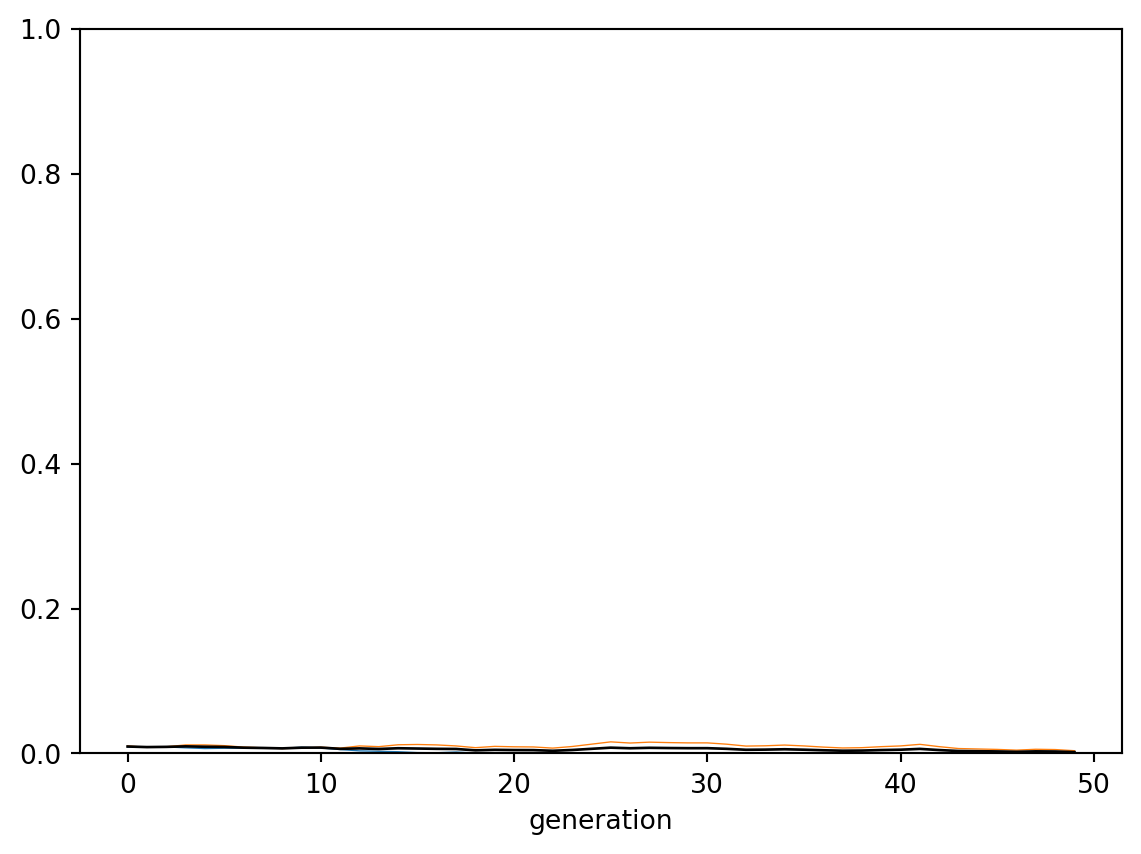

In [8]:
data_model = vertical_horizontal_transmission(N=5_000, p_0=0.01, b=0.5, n=5, g=0.1, t_max=50, r_max=2)
plot_multiple_runs(data_model)